In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Layer
import time
from matplotlib import pyplot as plt

In [11]:
class FBSNN(): # Forward-Backward Stochastic Neural Network
    def __init__(self, layers, Xi, T,
                       M, N, D):
        '''
        layers: list of number of neurons in each layer
        layers[1] is the input layer
        layers[-1] is the output layer normally 1
        '''
        # initial point
        self.Xi = Xi
        # terminal time
        self.T = T
        # number of trajectories
        self.M = M
        # number of time snapshots
        self.N = N
        # number of dimensions
        self.D = D

        # layers eg [100, 256, 256, 256, 256, 1]
        layers[0] = D+1
        self.layers = layers
        model = tf.keras.Sequential()
        for layer in layers[:-1]:
            model.add(Dense(layer, activation=None, kernel_initializer='glorot_normal', bias_initializer='zeros'))
            model.add(SinActivation())
        model.add(Dense(layers[-1]))
        self.model = model

    def call(self, inputs):
        return self.model(inputs)

    def optimizer(self, learning_rate):
        # return tf.keras.optimizers.legacy.Adam(learning_rate)
        return tf.keras.optimizers.Adam(learning_rate)

    def net_u(self, t, X): # M x 1, M x D
        with tf.GradientTape() as tape:
            tape.watch(X)
            u = self.model(tf.concat([t,X],1)) # M x 1
            Du = tape.gradient(u, X)[0] # M x D
        return u, Du

    def Dg_tf(self, X): # M x D
        with tf.GradientTape() as tape:
            tape.watch(X)
            return tape.gradient(self.g_tf(X), X)[0]

    def fetch_minibatch(self):
        T = self.T

        M = self.M
        N = self.N
        D = self.D

        Dt = np.zeros((M,N+1,1)) # M x (N+1) x 1
        DW = np.zeros((M,N+1,D)) # M x (N+1) x D

        dt = T/N

        Dt[:,1:,:] = dt
        DW[:,1:,:] = np.sqrt(dt)*np.random.normal(size=(M,N,D))

        t = np.cumsum(Dt,axis=1) # M x (N+1) x 1
        W = np.cumsum(DW,axis=1) # M x (N+1) x D
        t = tf.convert_to_tensor(t, dtype=tf.float32)
        W = tf.convert_to_tensor(W, dtype=tf.float32)

        return t, W

    def loss_function(self, t, W, Xi):
        loss = 0
        X_list = []
        Y_list = []

        t0 = t[:,0,:]
        W0 = W[:,0,:]
        X0 = tf.tile(Xi,[self.M,1]) # M x D
        Y0, Z0 = self.net_u(t0,X0) # M x 1, M x D

        X_list.append(X0)
        Y_list.append(Y0)

        for n in range(0,self.N):
            t1 = t[:,n+1,:]
            W1 = W[:,n+1,:]
            X1 = X0 + self.mu_tf(t0,X0,Y0,Z0)*(t1-t0) + tf.squeeze(tf.matmul(self.sigma_tf(t0,X0,Y0),tf.expand_dims(W1-W0,-1)), axis=[-1])
            Y1_tilde = Y0 + self.phi_tf(t0,X0,Y0,Z0)*(t1-t0) + tf.reduce_sum(Z0*tf.squeeze(tf.matmul(self.sigma_tf(t0,X0,Y0),tf.expand_dims(W1-W0,-1))), axis=1, keepdims = True)
            Y1, Z1 = self.net_u(t1,X1)

            loss += tf.reduce_sum(tf.square(Y1 - Y1_tilde))

            t0 = t1
            W0 = W1
            X0 = X1
            Y0 = Y1
            Z0 = Z1

            X_list.append(X0)
            Y_list.append(Y0)

        loss += tf.reduce_sum(tf.square(Y1 - self.g_tf(X1)))
        loss += tf.reduce_sum(tf.square(Z1 - self.Dg_tf(X1)))
        X = tf.stack(X_list,axis=1)
        Y = tf.stack(Y_list,axis=1)

        return loss, X, Y, Y[0,0,0]

    def train(self, N_Iter, learning_rate):
        optimizer = self.optimizer(learning_rate)
        start_time = time.time()
        loss_list = []
        for it in range(N_Iter):
            t_batch, W_batch = self.fetch_minibatch() # M x (N+1) x 1, M x (N+1) x D
            with tf.GradientTape() as tape:
                loss, X, Y, Y0 = self.loss_function(t_batch, W_batch, self.Xi)
                gradients = tape.gradient(loss, self.model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            elapsed = time.time() - start_time
            print(f'Epoch {it+1}/{N_Iter}, Loss: {loss.numpy()}, Time: {elapsed}')
            loss_list.append(loss.numpy())
            start_time = time.time()
        plt.plot(loss_list)
        plt.show()

    def predict(self, Xi_star, t_star, W_star):
        X_star = Xi_star + W_star
        Y_star = self.model(tf.concat([t_star, X_star], 2))
        return X_star.numpy(), Y_star.numpy()

    def phi_tf(self, t, X, Y, Z): # M x 1, M x D, M x 1, M x D
        return 0.05*(Y - tf.reduce_sum(X*Z, 1, keepdims = True)) # M x 1

    def g_tf(self, X):
        return tf.reduce_sum(X**2, 1, keepdims = True) # M x 1

    def mu_tf(self, t, X, Y, Z): # M x 1, M x D, M x 1, M x D
        M = self.M
        D = self.D
        return np.zeros([M,D]) # M x D

    def sigma_tf(self, t, X, Y): # M x 1, M x D, M x 1
        return 0.4*tf.linalg.diag(X) # M x D x D



class SinActivation(Layer):
    def __init__(self):
        super(SinActivation, self).__init__()

    def call(self, inputs):
        return tf.math.sin(inputs)

Epoch 1/20000, Loss: 538176.375, Time: 1.398601770401001
Epoch 2/20000, Loss: 486674.90625, Time: 1.1271908283233643
Epoch 3/20000, Loss: 439574.46875, Time: 1.1453003883361816
Epoch 4/20000, Loss: 396777.9375, Time: 1.1242339611053467
Epoch 5/20000, Loss: 377319.46875, Time: 1.1169557571411133
Epoch 6/20000, Loss: 371086.9375, Time: 1.0989978313446045
Epoch 7/20000, Loss: 351819.0625, Time: 1.1189618110656738
Epoch 8/20000, Loss: 322323.53125, Time: 1.1227588653564453
Epoch 9/20000, Loss: 318042.625, Time: 1.1081345081329346
Epoch 10/20000, Loss: 306550.5, Time: 1.1297476291656494
Epoch 11/20000, Loss: 287360.15625, Time: 1.1316113471984863
Epoch 12/20000, Loss: 290566.0, Time: 1.168440341949463
Epoch 13/20000, Loss: 292931.1875, Time: 1.1077964305877686
Epoch 14/20000, Loss: 284642.03125, Time: 1.1282222270965576
Epoch 15/20000, Loss: 279694.40625, Time: 1.1239354610443115
Epoch 16/20000, Loss: 291815.75, Time: 1.1614632606506348
Epoch 17/20000, Loss: 294861.0, Time: 1.09694862365722

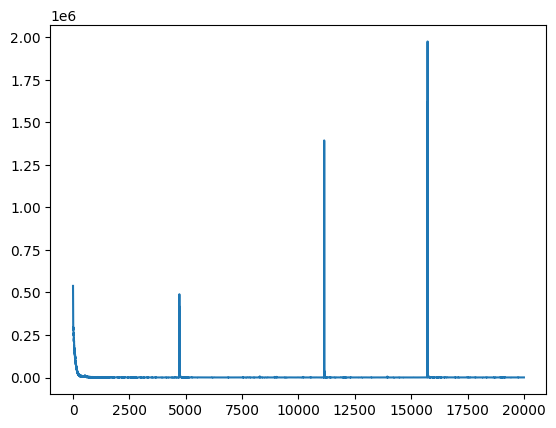

Epoch 1/30000, Loss: 319.2600402832031, Time: 1.2092444896697998
Epoch 2/30000, Loss: 396.6333923339844, Time: 1.1954762935638428
Epoch 3/30000, Loss: 421.44061279296875, Time: 1.1954705715179443
Epoch 4/30000, Loss: 536.58642578125, Time: 1.212240219116211
Epoch 5/30000, Loss: 393.892333984375, Time: 1.25791335105896
Epoch 6/30000, Loss: 544.1080932617188, Time: 1.1977999210357666
Epoch 7/30000, Loss: 457.1774597167969, Time: 1.1987018585205078
Epoch 8/30000, Loss: 393.0431823730469, Time: 1.2106850147247314
Epoch 9/30000, Loss: 337.28619384765625, Time: 1.273451328277588
Epoch 10/30000, Loss: 482.9097900390625, Time: 1.19594144821167
Epoch 11/30000, Loss: 342.2052307128906, Time: 1.2110421657562256
Epoch 12/30000, Loss: 490.55487060546875, Time: 1.196599006652832
Epoch 13/30000, Loss: 423.38592529296875, Time: 1.1953637599945068
Epoch 14/30000, Loss: 337.4132080078125, Time: 1.1945507526397705
Epoch 15/30000, Loss: 424.8885498046875, Time: 1.1952111721038818
Epoch 16/30000, Loss: 371

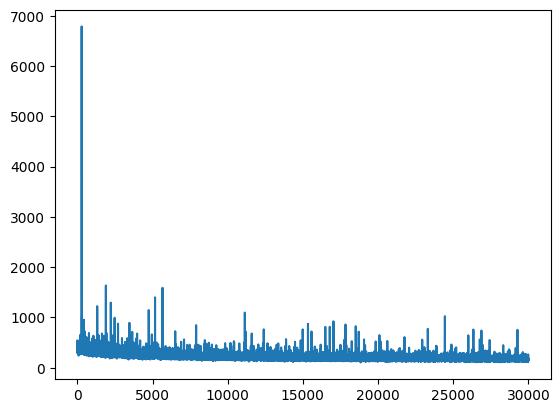

Epoch 1/30000, Loss: 155.0580596923828, Time: 1.4484350681304932
Epoch 2/30000, Loss: 152.655029296875, Time: 1.3971757888793945
Epoch 3/30000, Loss: 145.22605895996094, Time: 1.383690595626831
Epoch 4/30000, Loss: 137.218505859375, Time: 1.3843660354614258
Epoch 5/30000, Loss: 169.6702423095703, Time: 1.4135828018188477
Epoch 6/30000, Loss: 164.00341796875, Time: 1.3846521377563477
Epoch 7/30000, Loss: 141.94546508789062, Time: 1.399092197418213
Epoch 8/30000, Loss: 134.53762817382812, Time: 1.3998141288757324
Epoch 9/30000, Loss: 147.20132446289062, Time: 1.4001538753509521
Epoch 10/30000, Loss: 173.51101684570312, Time: 1.4480156898498535
Epoch 11/30000, Loss: 170.48162841796875, Time: 1.384270429611206
Epoch 12/30000, Loss: 190.11302185058594, Time: 1.4061028957366943
Epoch 13/30000, Loss: 134.6535186767578, Time: 1.3884916305541992
Epoch 14/30000, Loss: 187.966552734375, Time: 1.4310154914855957
Epoch 15/30000, Loss: 142.89910888671875, Time: 1.43027663230896
Epoch 16/30000, Loss:

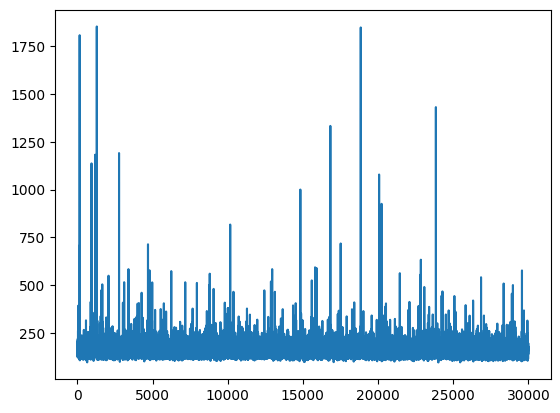

Epoch 1/20000, Loss: 152.51731872558594, Time: 1.984492540359497
Epoch 2/20000, Loss: 161.25270080566406, Time: 1.9486165046691895
Epoch 3/20000, Loss: 147.17430114746094, Time: 1.9485018253326416
Epoch 4/20000, Loss: 136.60537719726562, Time: 1.979196310043335
Epoch 5/20000, Loss: 158.48516845703125, Time: 1.9953737258911133
Epoch 6/20000, Loss: 140.39620971679688, Time: 1.9485435485839844
Epoch 7/20000, Loss: 162.98912048339844, Time: 1.942333698272705
Epoch 8/20000, Loss: 131.73208618164062, Time: 1.9595353603363037
Epoch 9/20000, Loss: 148.54876708984375, Time: 1.9482898712158203
Epoch 10/20000, Loss: 143.4203643798828, Time: 1.9473481178283691
Epoch 11/20000, Loss: 127.22587585449219, Time: 1.960923194885254
Epoch 12/20000, Loss: 216.00753784179688, Time: 1.9351170063018799
Epoch 13/20000, Loss: 194.17135620117188, Time: 1.9366679191589355
Epoch 14/20000, Loss: 134.148681640625, Time: 1.9644184112548828
Epoch 15/20000, Loss: 161.93658447265625, Time: 1.9459614753723145
Epoch 16/20

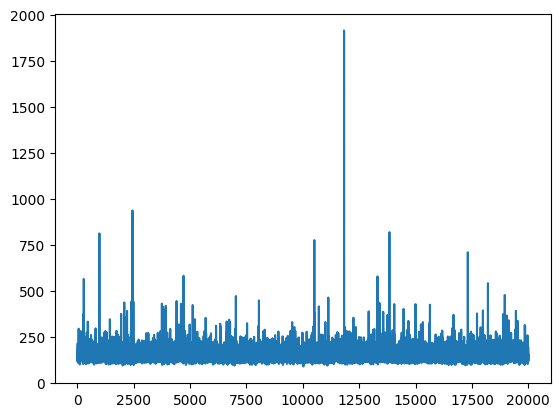

In [13]:
M = 100  # number of trajectories (batch size)
N = 50  # number of time snapshots
D = 100  # number of dimensions
T = 1.0
Xi = np.array([1.0,0.5]*int(D/2))[None,:]
Xi = tf.convert_to_tensor(Xi, dtype=tf.float32)
layers = [D+1] + 4*[256] + [1]

model = FBSNN(layers, Xi, T, M, N, D)
model.train(N_Iter = 2*10**4, learning_rate=1e-3)
model.train(N_Iter = 3*10**4, learning_rate=1e-4)
model.train(N_Iter = 3*10**4, learning_rate=1e-5)
model.train(N_Iter = 2*10**4, learning_rate=1e-6)

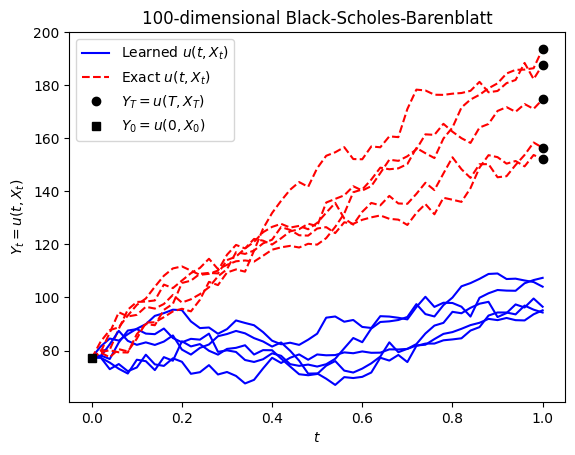

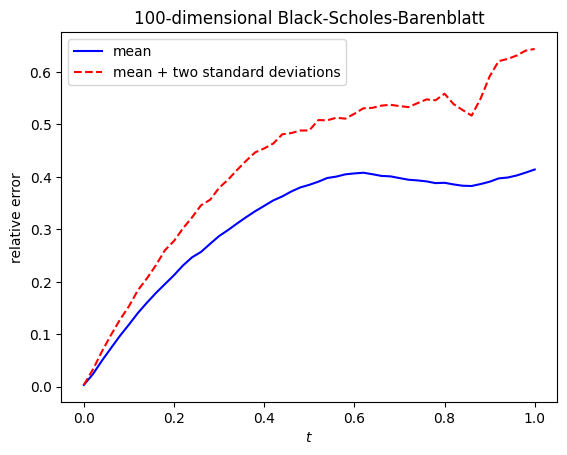

In [14]:
t_test, W_test = model.fetch_minibatch()

X_pred, Y_pred = model.predict(Xi, t_test, W_test)

def u_exact(t, X): # (N+1) x 1, (N+1) x D
    r = 0.05
    sigma_max = 0.4
    return np.exp((r + sigma_max**2)*(T - t))*np.sum(X**2, 1, keepdims = True) # (N+1) x 1

Y_test = np.reshape(u_exact(np.reshape(t_test[0:M,:,:],[-1,1]), np.reshape(X_pred[0:M,:,:],[-1,D])),[M,-1,1])

samples = 5

plt.figure()
plt.plot(t_test[0:1,:,0].numpy().T,Y_pred[0:1,:,0].T,'b',label='Learned $u(t,X_t)$')
plt.plot(t_test[0:1,:,0].numpy().T,Y_test[0:1,:,0].T,'r--',label='Exact $u(t,X_t)$')
plt.plot(t_test[0:1,-1,0],Y_test[0:1,-1,0],'ko',label='$Y_T = u(T,X_T)$')

plt.plot(t_test[1:samples,:,0].numpy().T,Y_pred[1:samples,:,0].T,'b')
plt.plot(t_test[1:samples,:,0].numpy().T,Y_test[1:samples,:,0].T,'r--')
plt.plot(t_test[1:samples,-1,0],Y_test[1:samples,-1,0],'ko')

plt.plot([0],Y_test[0,0,0],'ks',label='$Y_0 = u(0,X_0)$')

plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title('100-dimensional Black-Scholes-Barenblatt')
plt.legend()

# savefig('./figures/BSB_Apr18_50', crop = False)


errors = np.sqrt((Y_test-Y_pred)**2/Y_test**2)
mean_errors = np.mean(errors,0)
std_errors = np.std(errors,0)

plt.figure()
plt.plot(t_test[0,:,0],mean_errors,'b',label='mean')
plt.plot(t_test[0,:,0],mean_errors+2*std_errors,'r--',label='mean + two standard deviations')
plt.xlabel('$t$')
plt.ylabel('relative error')
plt.title('100-dimensional Black-Scholes-Barenblatt')
plt.legend()

# savefig('./figures/BSB_Apr18_50_errors', crop = False)